In [1]:
from scipy.io import loadmat
import numpy as np

In [2]:
mesh = loadmat("meshes/voronoi.mat")

In [3]:
def f(x, y):
    return 15 * np.sin(np.pi*x) * np.sin(np.pi*y)

def g(x, y):
    return (1-x) * y * np.sin(np.pi*x)

In [4]:
boundary = mesh['boundary'].flatten() - 1
elements = np.array([list(y.flatten() - 1 for y in x) for x in mesh['elements']]).squeeze()
vertices = mesh['vertices']

C:\ProgramData\Miniconda3\envs\nrrrc\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


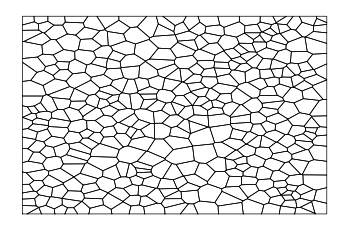

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
for element in elements:
    x = [vertices[x][0] for x in element]
    x.append(x[0])
    y = [vertices[x][1] for x in element]
    y.append(y[0])
    plt.plot(x,y, c="black", linewidth=0.7)
plt.axis('off')
plt.savefig('mesh_triangles.png')

In [11]:
A = np.zeros((len(vertices), len(vertices)))
F = np.zeros(len(vertices))
u = np.zeros(len(vertices))
poly_grads = np.array([[0,0],[1,0],[0,1]])
for element in elements:
    local_vertices = vertices[element]
    x = local_vertices[:, 0]
    y = local_vertices[:, 1]
    n_of_sides = len(element)
    range_plus_one = np.array([*range(1,n_of_sides),0])
    area_part = np.array([x[i]*y[j] - x[j]*y[i] for i, j in zip(range(n_of_sides), range_plus_one)])
    area = np.abs(1/2 * np.sum(area_part))
    centroid = 1/(6*area) * np.sum([(d + d[range_plus_one]) * area_part for d in [x,y]], axis=1)
    diameter = np.max([np.linalg.norm(local_vertices[i] - local_vertices[j]) for i in range(n_of_sides) for j in range(i+1,n_of_sides)])
    D = np.zeros((n_of_sides, len(poly_grads)))
    D[:,0] = 1
    B_snake = np.zeros((len(poly_grads),n_of_sides))
    B_snake[0,:] = 1/n_of_sides
    for vertex_id in range(n_of_sides):
        vert = local_vertices[vertex_id]
        previous = local_vertices[vertex_id-1]
        next = local_vertices[(vertex_id+1) % n_of_sides]
        vertex_normal = np.array([next[1] - previous[1], previous[0] - next[0]])
        for i, poly_grad in zip(range(1, len(poly_grads)), poly_grads[1:]):
            B_snake[i, vertex_id] = np.dot(vertex_normal, poly_grad) / (2 * diameter)
            D[vertex_id, i] = np.dot(vert - centroid, poly_grad) / diameter
    projector = np.linalg.solve(B_snake @ D, B_snake)
    G = B_snake @ D
    G[0,:] = 0
    part = np.eye(n_of_sides) - D @ projector
    stabilizing_term = part.T @ part
    local_stiffness = ((projector.T @ G) @ projector) + 0 * stabilizing_term
    A[np.ix_(element,element)] += local_stiffness
    F[element] = F[element] + f(centroid[0], centroid[1]) * area / n_of_sides
boundary_vals = g(vertices[boundary][:,0],vertices[boundary][:,1])
internal_vertices = ~np.isin(np.arange(len(vertices)), boundary)
u[internal_vertices] = np.linalg.solve(A[np.ix_(internal_vertices, internal_vertices)], F[internal_vertices] - A[np.ix_(np.where(internal_vertices)[0],np.where(~internal_vertices)[0])] @ boundary_vals)
u[~internal_vertices] = boundary_vals

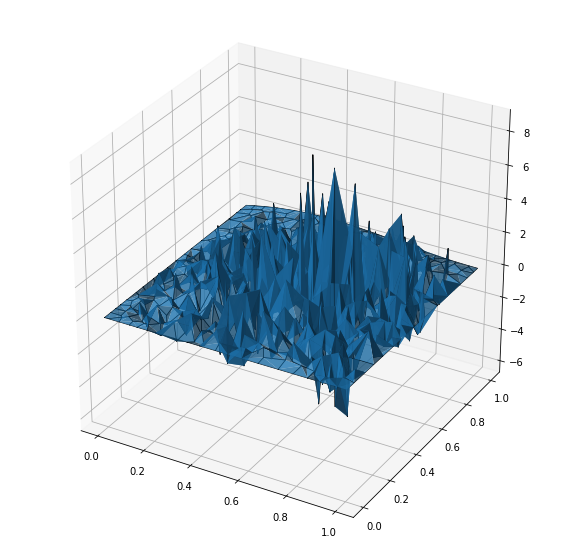

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
x = vertices[:, 0]
y = vertices[:, 1]
z = u

plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

for element in elements:
    x_e = [vertices[v][0] for v in element]
    x_e.append(x_e[0])
    y_e = [vertices[v][1] for v in element]
    y_e.append(y_e[0])
    z_e = np.append(u[element],u[element[0]])
    plt.plot(x_e,y_e,z_e, c="black", linewidth=0.7)
ax.plot_trisurf(x, y, z, alpha=0.8, edgecolor="none")
plt.savefig('result-poisson-voronoi-without-st.png')

In [16]:
A = np.zeros((len(vertices), len(vertices)))
F = np.zeros(len(vertices))
u = np.zeros(len(vertices))
poly_grads = np.array([[0,0],[1,0],[0,1]])
for element in elements:
    local_vertices = vertices[element]
    x = local_vertices[:, 0]
    y = local_vertices[:, 1]
    n_of_sides = len(element)
    range_plus_one = np.array([*range(1,n_of_sides),0])
    area_part = np.array([x[i]*y[j] - x[j]*y[i] for i, j in zip(range(n_of_sides), range_plus_one)])
    area = np.abs(1/2 * np.sum(area_part))
    centroid = 1/(6*area) * np.sum([(d + d[range_plus_one]) * area_part for d in [x,y]], axis=1)
    diameter = np.max([np.linalg.norm(local_vertices[i] - local_vertices[j]) for i in range(n_of_sides) for j in range(i+1,n_of_sides)])
    D = np.zeros((n_of_sides, len(poly_grads)))
    D[:,0] = 1
    B_snake = np.zeros((len(poly_grads),n_of_sides))
    B_snake[0,:] = 1/n_of_sides
    for vertex_id in range(n_of_sides):
        vert = local_vertices[vertex_id]
        previous = local_vertices[vertex_id-1]
        next = local_vertices[(vertex_id+1) % n_of_sides]
        vertex_normal = np.array([next[1] - previous[1], previous[0] - next[0]])
        for i, poly_grad in zip(range(1, len(poly_grads)), poly_grads[1:]):
            B_snake[i, vertex_id] = np.dot(vertex_normal, poly_grad) / (2 * diameter)
            D[vertex_id, i] = np.dot(vert - centroid, poly_grad) / diameter
    projector = np.linalg.solve(B_snake @ D, B_snake)
    G = B_snake @ D
    G[0,:] = 0
    part = np.eye(n_of_sides) - D @ projector
    stabilizing_term = part.T @ part
    local_stiffness = ((projector.T @ G) @ projector) + stabilizing_term
    A[np.ix_(element,element)] += local_stiffness
    F[element] = F[element] + f(centroid[0], centroid[1]) * area / n_of_sides
boundary_vals = g(vertices[boundary][:,0],vertices[boundary][:,1])
internal_vertices = ~np.isin(np.arange(len(vertices)), boundary)
u[internal_vertices] = np.linalg.solve(A[np.ix_(internal_vertices, internal_vertices)], F[internal_vertices] - A[np.ix_(np.where(internal_vertices)[0],np.where(~internal_vertices)[0])] @ boundary_vals)
u[~internal_vertices] = boundary_vals

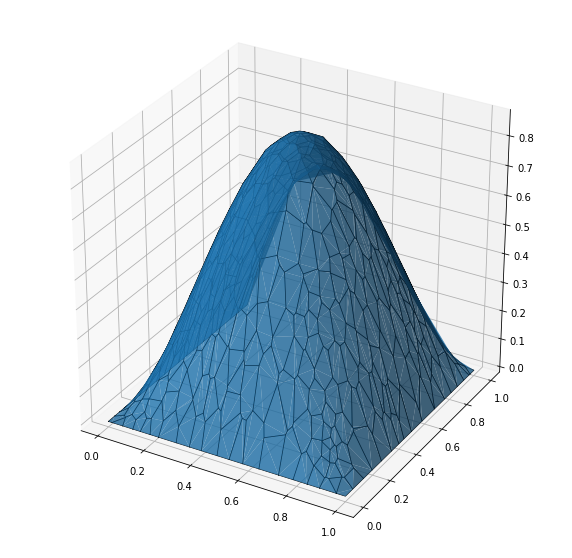

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
x = vertices[:, 0]
y = vertices[:, 1]
z = u

plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

for element in elements:
    x_e = [vertices[v][0] for v in element]
    x_e.append(x_e[0])
    y_e = [vertices[v][1] for v in element]
    y_e.append(y_e[0])
    z_e = np.append(u[element],u[element[0]])
    plt.plot(x_e,y_e,z_e, c="black", linewidth=0.7)
ax.plot_trisurf(x, y, z, alpha=0.8, edgecolor="none")
plt.savefig("result-poisson-voronoi-with-st.png")

array([[ 2.85114731e-34, -2.15262961e-33,  4.98038008e-34],
       [-2.15262961e-33,  2.23467679e-32,  2.97244585e-33],
       [ 4.98038008e-34,  2.97244585e-33,  8.69972088e-33]])